# Compare random vs sequential input
It seems like the COSMOS15 test catalog is not completely random, and the statistics change if we use the first 1k, or if we use the first 10k.
See [#16326](https://redmine.isdc.unige.ch/issues/16326).

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import subprocess
import sys
import time

from astropy.table import Table
from astropy.io import fits

In [2]:
nnpz_dir = '/home/aalvarez/Work/Projects/NNPZ'
nnpz_bin = os.path.join(nnpz_dir, 'bin', 'nnpz')
nnpzphoto_bin = os.path.join(nnpz_dir, 'bin', 'NnpzBuildPhotometry')
reference_sample = '/home/aalvarez/Work/Data/dc3/ReferenceSample'
reference_sample_photo = '/home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits'
nnpz_env = os.environ.copy()
nnpz_env['PYTHONPATH'] = nnpz_env.get('PYTHONPATH', '') + ':' + nnpz_dir

output_dir = '/tmp/validate_random/'

input_size = 1000

In [3]:
nnpz_original_config_file = '/home/aalvarez/Work/Data/coupon/nnpz.conf'
target_catalog = '/home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits'
fluxes_file = '/home/aalvarez/Work/Data/coupon/fluxes.fits'

In [4]:
def run_nnpz(nnpz_bin, nnpz_config, nnpz_env):
    nnpz_config_file = '/tmp/nnpz_tests/nnpz.conf'
    if os.path.exists(nnpz_config_file):
        os.unlink(nnpz_config_file)

    if os.path.exists(nnpz_config['output_file']):
        print(f"{nnpz_config['output_file']} already exists, so skipping run")
        return 0
        
    with open(nnpz_config_file, mode='w') as fd:
        for key, value in nnpz_config.items():
            if not key.startswith('_'):
                if isinstance(value, str):
                    print(f'{key} = "{value}"', file=fd)
                else:
                    print(f'{key} = {value}', file=fd)

    start = time.monotonic()
    nnpz_proc = subprocess.Popen(
        [nnpz_bin, nnpz_config_file],
        env=nnpz_env, stdout=subprocess.PIPE, stderr=subprocess.STDOUT
    )
    while nnpz_proc.poll() is None:
        print(nnpz_proc.stdout.readline().decode('utf-8'), end='')
    end = time.monotonic()
    return end - start

In [26]:
def plot_matching(reference, target):
    if len(reference) != len(target):
        raise Exception("Reference and target sizes do not match")
    if not np.all(reference['ID'] == target['ID']):
        raise Exception("Reference and target objects ID do not match")
    max_count = reference['NeighborIDs'].shape[1]
    counts = np.zeros(max_count + 1) # One position per count (so 0 to as many neighbours in the reference)
    for r, t in zip(reference, target):
        c = np.isin(r['NeighborIDs'], t['NeighborIDs']).sum()
        counts[c] += 1
    plt.hist(range(max_count + 1), weights=counts, bins=max_count+1)
    return counts

In [6]:
nnpz_config = {}
with open(nnpz_original_config_file) as fd:
    exec(fd.read(), nnpz_config)

## Sequential

### Run real neighbours

In [7]:
real_output_file = os.path.join(output_dir, 'Real.fits')

nnpz_config['reference_sample_dir'] = reference_sample
nnpz_config['reference_sample_phot_file'] = '/tmp/nnpz_tests/Shift9ReferencePhotometry.fits'
nnpz_config['target_catalog'] = target_catalog
nnpz_config['target_catalog_filters'] = [
    ('u_obs', 'u_obs_err'),
    ('g_obs', 'g_obs_err'),
    ('r_shift9_obs', 'r_shift9_obs_err'),
    ('i_obs', 'i_obs_err'),
    ('z_obs', 'z_obs_err'),
    ('vis_obs', 'vis_obs_err'),
    ('Y_obs', 'Y_obs_err'),
    ('J_obs', 'J_obs_err'),
    ('H_obs', 'H_obs_err')
]
nnpz_config['target_catalog_filters_mean'] = None
nnpz_config['input_size'] = input_size
nnpz_config['input_method'] = None
nnpz_config['neighbor_method'] = 'BruteForce'
nnpz_config['neighbors_no'] = 30
nnpz_config['output_file'] = real_output_file
if 'pdz_mc_samples' in nnpz_config:
    del nnpz_config['pdz_mc_samples']

In [8]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    input_method : None
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /tmp/validate_random/Real.fits
    copy_input_columns : True
    reference_sample_phot_file : /tmp/nnpz_tests/Shift9ReferencePhotometry.fits
    weight_method : Likelihood
    input_size : 1000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 2000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_shift9_obs', 'r_shift9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : ['u', 'g', 'r', 'i', 'z', 'vis

### Run against 1k batch, sequential

In [9]:
sequential_output_file = os.path.join(output_dir, 'Sequential.fits')

nnpz_config['reference_sample_phot_file'] = reference_sample_photo
nnpz_config['neighbor_method'] = 'Combined'
nnpz_config['batch_size'] = 1000
nnpz_config['neighbors_no'] = 30
nnpz_config['output_file'] = sequential_output_file

In [10]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    input_method : None
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /tmp/validate_random/Sequential.fits
    copy_input_columns : True
    reference_sample_phot_file : /home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits
    weight_method : Likelihood
    input_size : 1000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_shift9_obs', 'r_shift9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : ['u', 'g', 'r', 'i', 'z'

### Compare

In [11]:
real = Table.read(real_output_file)
combined_seq = Table.read(sequential_output_file)

<IPython.core.display.Javascript object>


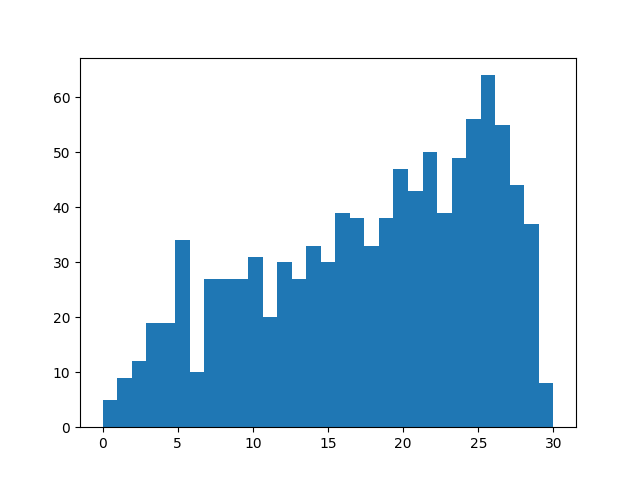

array([  5.,   9.,  12.,  19.,  19.,  34.,  10.,  27.,  27.,  27.,  31.,
        20.,  30.,  27.,  33.,  30.,  39.,  38.,  33.,  38.,  47.,  43.,
        50.,  39.,  49.,  56.,  64.,  55.,  44.,  37.,   8.])

In [27]:
plot_matching(real, combined_seq)

## Randomize
Do the same, but randomize the input.

### Real

In [13]:
random_real_output_file = os.path.join(output_dir, 'RandomReal.fits')

nnpz_config['reference_sample_phot_file'] = '/tmp/nnpz_tests/Shift9ReferencePhotometry.fits'
nnpz_config['input_method'] = 'random'
nnpz_config['input_seed'] = 0
nnpz_config['neighbor_method'] = 'BruteForce'
nnpz_config['neighbors_no'] = 30
nnpz_config['output_file'] = random_real_output_file

In [14]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    input_method : random
    target_transmission_provider : shifted
    input_seed : 0
    log_level : DEBUG
    output_file : /tmp/validate_random/RandomReal.fits
    copy_input_columns : True
    reference_sample_phot_file : /tmp/nnpz_tests/Shift9ReferencePhotometry.fits
    weight_method : Likelihood
    input_size : 1000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_shift9_obs', 'r_shift9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : ['u

### Combined

In [15]:
random_output_file = os.path.join(output_dir, 'RandomSequential.fits')

nnpz_config['reference_sample_phot_file'] = reference_sample_photo
nnpz_config['neighbor_method'] = 'Combined'
nnpz_config['batch_size'] = 1000
nnpz_config['neighbors_no'] = 30
nnpz_config['output_file'] = random_output_file

In [16]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    input_method : random
    target_transmission_provider : shifted
    input_seed : 0
    log_level : DEBUG
    output_file : /tmp/validate_random/RandomSequential.fits
    copy_input_columns : True
    reference_sample_phot_file : /home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits
    weight_method : Likelihood
    input_size : 1000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_shift9_obs', 'r_shift9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters

In [17]:
random_real = Table.read(random_real_output_file)
random_combined = Table.read(random_output_file)

<IPython.core.display.Javascript object>


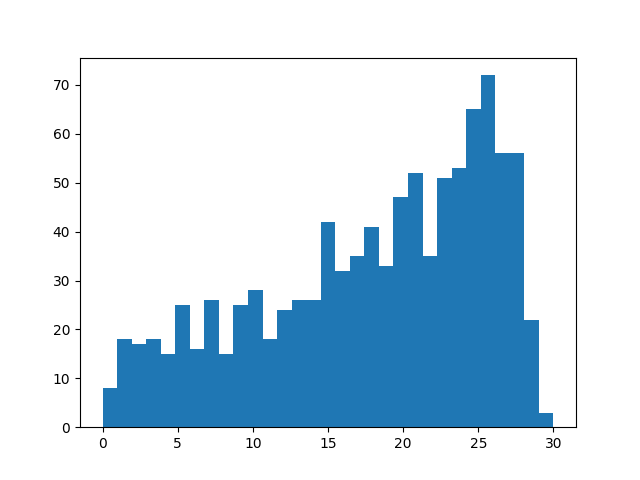

array([  8.,  18.,  17.,  18.,  15.,  25.,  16.,  26.,  15.,  25.,  28.,
        18.,  24.,  26.,  26.,  42.,  32.,  35.,  41.,  33.,  47.,  52.,
        35.,  51.,  53.,  65.,  72.,  56.,  56.,  22.,   3.])

In [28]:
plot_matching(random_real, random_combined)

In [19]:
np.all(np.isin(random_real['ID'], real['ID']))

False